## **Import the TensorFlow library**

This code contains a small script that is ised for generating a folder full of images. The idea is to show these images to the OpenMV camera when the training with the OL methos is required. Since the idea is to apply a supervised training is required to have a ground truth forthe computation of the error that the model is doing. This script fills a directory with images of digits and creates a txt file in which all the labels are saved. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
import random
import os
import csv 
import pandas as pd
import re
import random
import matplotlib.image as mpimg
from tensorflow.keras import optimizers
from PIL import Image
import seaborn as sns

from myLib import *

# LOAD DATASETS

In [2]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes from MNIST are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes from MNIST are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


In [3]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]
img_rows, img_cols = 28, 28

trainLow_samples = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples  = np.sum(np.where(label_test  < 6, 1, 0))

# separate in containers data that is lower and higer than 6
# TRAIN - LOW
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
#       - HIGH
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

# TEST - LOW
data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)
#      - HIGH
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1

j,k = 0,0
for i in range(0,test_samples):  
    if(label_test[i]<6):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1
    else:
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1

In [4]:
# Does something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
    
print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28, 1)
     Train dataset higher than 6 has shape: (23983, 28, 28, 1)

     Test dataset lower than 6 has shape:  (6031, 28, 28, 1)
     Test dataset higher than 6 has shape: (3969, 28, 28, 1)


In [5]:
# Normalize the colors from 0-255 to 0-1
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

In [6]:
# EXTRACT SOME SAMPLES FROM THE BIG DATASETS TO CREATE OL TRAINIGN AND TESTING DATASET
digits_train, labels_train = extract_tot_samples(data_low_train, data_high_train, label_low_train, label_high_train,50)
digits_test, labels_test   = extract_tot_samples(data_low_train, data_high_train, label_low_train, label_high_train,50)


print(f'Digits train shape is {digits_train.shape}')
print(f'Digits test shape is {digits_test.shape}')

Digits train shape is (500, 28, 28, 1)
Digits test shape is (500, 28, 28, 1)


In [7]:
# SHUFFLE THE DATASETS
digits_train, labels_train = shuffleDataset(digits_train, labels_train)
digits_test, labels_test   = shuffleDataset(digits_test, labels_test)


# LOAD TF TRAINED MODEL

In [8]:
ROOT_PATH = os.path.abspath('')
MODEL_PATH = ROOT_PATH + "/Saved_models/"

In [9]:
model = keras.models.load_model(MODEL_PATH + 'Original_model/mnist_cnn.h5')

# FUNCTIONS

In [10]:
class Custom_Layer(object):
    def __init__(self, model):

        # Related to the layer
        self.ML_frozen = keras.models.Sequential(model.layers[:-1])  # extract the last layer from the original model
        self.ML_frozen.compile()
        
        self.W = np.array(model.layers[-1].get_weights()[0])    # extract the weights from the last layer
        self.b = np.array(model.layers[-1].get_weights()[1])    # extract the biases from the last layer
               
        self.W_2 = np.zeros(self.W.shape)
        self.b_2 = np.zeros(self.b.shape)
        
        self.label     = ['0','1','2','3','4','5']              
        self.std_label = ['0','1','2','3','4','5','6','7','8','9']
        
        self.l_rate = 0                                         # learning rate that changes depending on the algorithm        

        self.batch_size = 0
        
        # Related to the results fo the model
        self.conf_matr = np.zeros((10,10))    # container for the confusion matrix       
        self.macro_avrg_precision = 0       
        self.macro_avrg_recall = 0
        self.macro_avrg_F1score = 0
        
        self.title = ''       # title that will be displayed on plots
        self.filename = ''    # name of the files to be saved (plots, charts, conf matrix)
        
        
    # Function that is used for the prediction of the model saved in this class
    def predict(self, x):
        mat_prod = np.array(np.matmul(x, self.W) + self.b)
        return  myFunc_softmax(mat_prod) # othwerwise do it with keras|also remove np.array()| tf.nn.softmax(mat_prod) 

In [11]:
def digitToSoftmax(current_label, known_labels):
    ret_ary = np.zeros(len(known_labels))

    known_labels_2 = [0,1,2,3,4,5]
                       
    for i in range(0, len(known_labels)):
        if(current_label == known_labels_2[i]):
            ret_ary[i] = 1

    return ret_ary  


In [12]:
def trainOneEpoch_OL(model, x_train, x_test, y_train, y_test):
    
    print('**********************************\nPerforming training with OL METHOD\n')
   
    cntr = 1
    learn_rate    = model.l_rate
    
    train_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    tot_samples = train_samples+test_samples
                
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        if(i<train_samples):
            current_label = y_train[i]
        else:
            current_label = y_test[i-train_samples]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label)
               
        # PPREDICTION
        if(i<train_samples):
            y_ML = model.ML_frozen.predict(x_train[i].reshape((1,28,28,1)))
        else:
            y_ML = model.ML_frozen.predict(x_test[i-train_samples].reshape((1,28,28,1)))
        y_pred = model.predict(y_ML[0,:])           
        
        # BACKPROPAGATION
        cost = y_pred-y_true_soft
        
        for j in range(0,model.W.shape[0]):
            # Update weights
            dW = np.multiply(cost, y_ML[0,j]*learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db      = np.multiply(cost, learn_rate)
        model.b = model.b-db
        

        
        # if the train data is finished still train the model but save the results
        if(i>=train_samples):
            
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1    
        
        print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        cntr +=1

In [16]:
def predict_kreas(model, x_test, y_test):
    
    print('**********************************\nPerforming training with OL METHOD\n')
   
    cntr = 1    
    test_samples = x_test.shape[0]
                
    # Cycle over all samples
    for i in range(0, test_samples):
        
        current_label = y_test[i]
        
        y_true_soft = digitToSoftmax(current_label, model.label)               
        # PPREDICTION
        y_ML   = model.ML_frozen.predict(x_test[i].reshape((1,28,28,1)))
        y_pred = model.predict(y_ML[0,:])                 


        # Find the max iter for both true label and prediction
        max_i_true= 100
        if(np.amax(y_true_soft) != 0):
            max_i_true = np.argmax(y_true_soft)

        if(np.amax(y_pred) != 0):
            max_i_pred = np.argmax(y_pred)

        # Fill up the confusion matrix
        for k in range(0,len(model.label)):
            if(model.label[max_i_pred] == model.std_label[k]):
                p = np.copy(k)
            if(model.label[max_i_true] == model.std_label[k]):
                t = np.copy(k)

        model.conf_matr[t,p] += 1    
        
        print(f"\r    Currently at {np.round(np.round(cntr/test_samples,4)*100,2)}% of dataset", end="")
        cntr +=1  

**********************************
Performing training with OL METHOD

    Currently at 100.0% of dataset

C:\Users\massi\UNI\Magistrale\Anno 5\Semestre 2\Tesi\Code\OpenMV_application\Training_scripts\myLib.py:200: RuntimeWarning: invalid value encountered in double_scalars
  bar_values[i] = round(round(conf_matr[i,i]/sum(conf_matr[i,:]),4)*100, 2)      # Accuracy for each letter


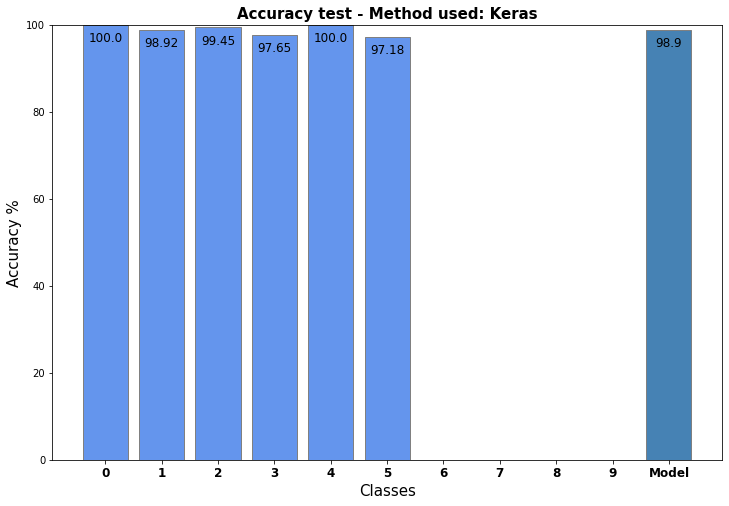

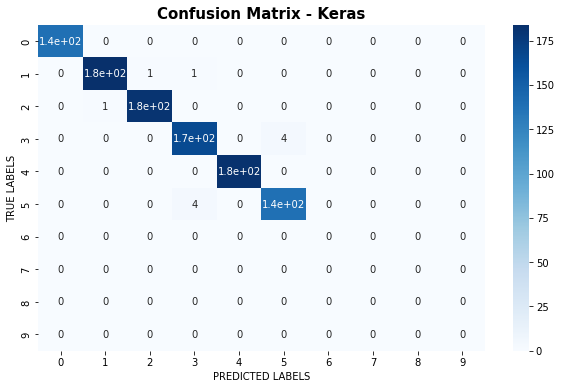

In [20]:
Model_KERAS = Custom_Layer(model)
Model_KERAS.title      = 'Keras' 
Model_KERAS.filename   = 'Keras'
Model_KERAS.l_rate     = 0
Model_KERAS.batch_size = 8

predict_kreas(Model_KERAS, data_low_test[:1000], label_low_test[:1000])

plot_barChart(Model_KERAS)
plot_confMatrix(Model_KERAS)

**********************************
Performing training with OL METHOD

    Currently at 0.3% of dataset

    New letter detected -> letter 7 

    Currently at 0.6% of dataset

    New letter detected -> letter 6 

    Currently at 0.9% of dataset

    New letter detected -> letter 9 

    Currently at 1.7% of dataset

    New letter detected -> letter 8 

    Currently at 100.0% of dataset

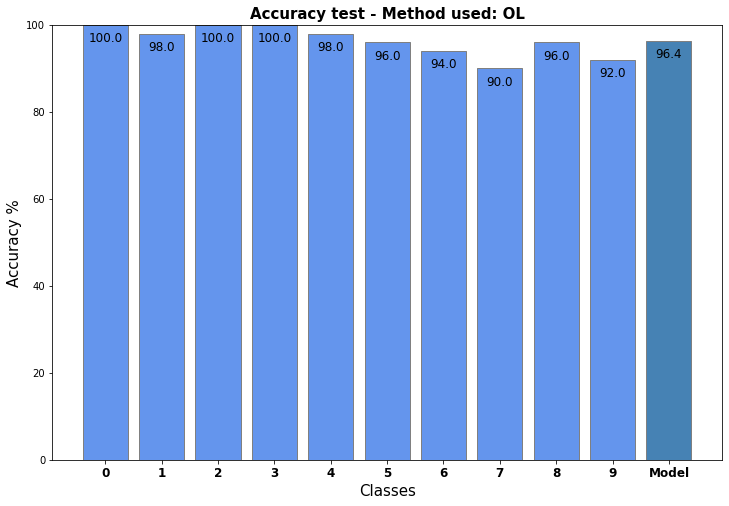

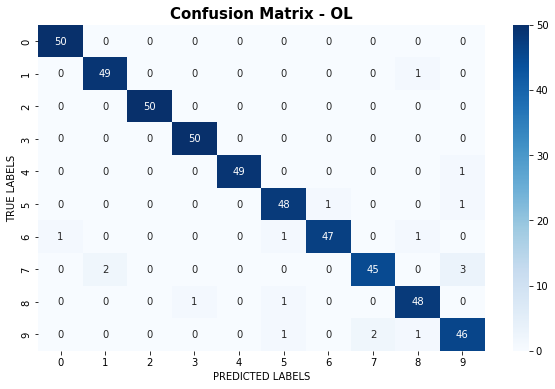

In [25]:
Model_OL = Custom_Layer(model)
Model_OL.title      = 'OL' 
Model_OL.filename   = 'OL'
Model_OL.l_rate     = 0.01 
Model_OL.batch_size = 8

trainOneEpoch_OL(Model_OL, digits_train, digits_test, labels_train, labels_test)

plot_barChart(Model_OL)
plot_confMatrix(Model_OL)